In [43]:
import sys

sys.path.append("/home/boittier/Documents/phd/water-knn/analysis")

In [44]:
from ir import *

from pint import UnitRegistry
import warnings

# ignore the casting errors for units
warnings.simplefilter("ignore")
ureg = UnitRegistry()

#  matplotlib styles
plt.style.use(["science", "no-latex", "ieee"])

#  constants
Avogadro_const = 6.02214129 * 10**23 * ureg("mol^-1")  # % mol-1

def get_density(volume, N_res, MW):
    """
    get the density of the simulation for a given volume, number of molecules and
    molecular weight :param volume: m^3 :param N_res: number :param MW: g/mol
    :return: density in g/m^3
    """
    MW = MW * ureg("g/mol")

    return (N_res * MW) / (Avogadro_const * volume)

(5699939, 3)
Nframes:  5699939
ACV:  (5699939,)
O$_{r_{min}/2}$ = 1.7653
$\rho$ = 1.005
Volume:  59468.16964 angstrom ** 3
D_omega:  0.029260321487488906
N_freq:  2849970
572.7415327961079 0.001566498798526791
1750.0305678452241 0.0014039997953890632
3870.46754540057 0.0008826223931149892
(9803921, 3)
Nframes:  9803921
ACV:  (9803921,)
O$_{r_{min}/2}$ = 1.77
$\rho$ = 0.987
Volume:  60550.59819 angstrom ** 3
D_omega:  0.017011769841788406
N_freq:  4901961
574.6235617159288 0.0015137270316421955
1745.5096563865413 0.001456651701155994
3876.9142998642105 0.0008389786121659225
(9803921, 3)
Nframes:  9803921
ACV:  (9803921,)
O$_{r_{min}/2}$ = 1.775
$\rho$ = 0.985
Volume:  60703.2024 angstrom ** 3
D_omega:  0.017011769841788406
N_freq:  4901961
533.2169139210158 0.0015064980170277629
1744.0636559499894 0.0014890754604901877
3877.57775888804 0.0008509292668071745
(5250499, 3)
Nframes:  5250499
ACV:  (5250499,)
O$_{r_{min}/2}$ = 1.80
$\rho$ = 0.752
Volume:  79507.0 angstrom ** 3
D_omega:  0.03

Text(0.5, 0, 'Freq. [cm$^-1$]')

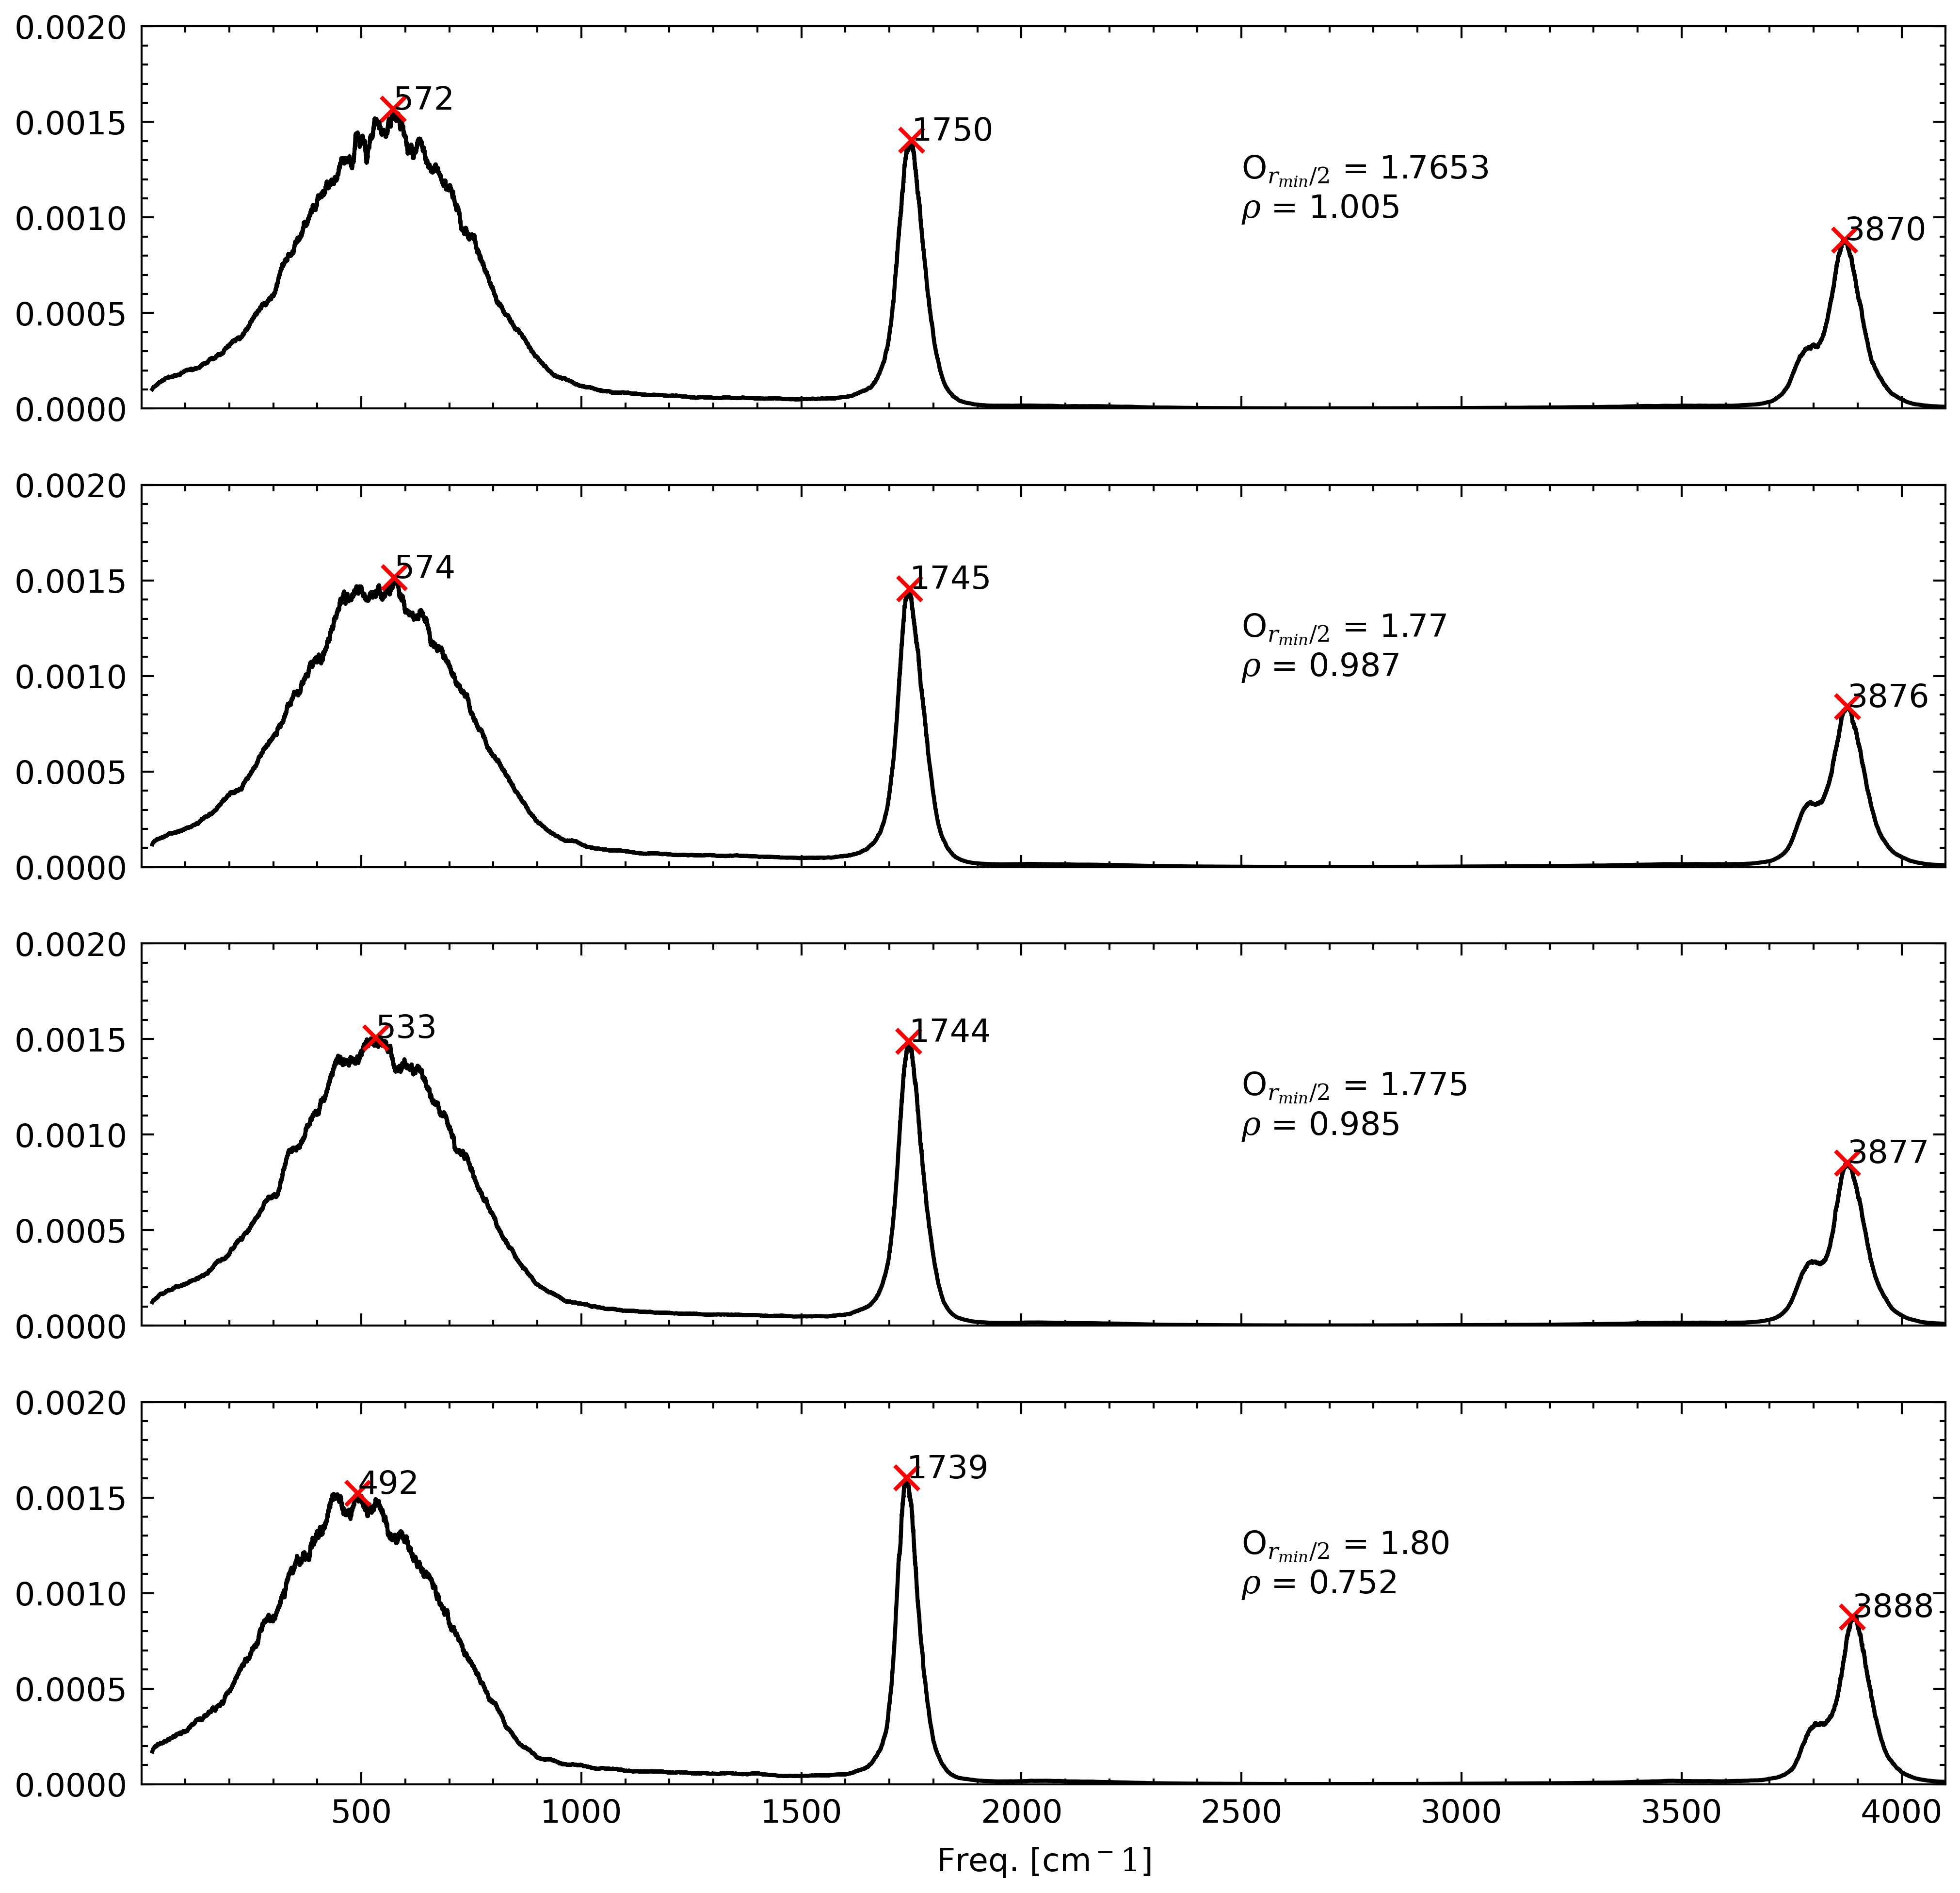

In [48]:
timestep = 0.0002


files = [
    # "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a/fort.14_ir_cpt",
    "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a/fort.14",
    "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a_vdw/fort.14",
    "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a_vdw2/fort.14",
    "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a_vdw3/fort.14",
    # "/home/boittier/pcbach/waterlj/kparms-4.0-d594b332-5427-4d8a-9b79-64f1ac10ed1a/single_water/fort.14",

]


fig, ax = plt.subplots(4,1, sharex=True,sharey=True, figsize=(8,8))


for i, file in enumerate(files):
    data = read_dat_file(file)
    print(data.shape)
    freq, spectra = autocorrelation_ft(data, timestep, verbose=True)
    filename = Path(file).parent.name
    if i < 4:
        params = find_O_params(Path(file).parent)
        volume_ = find_volume(Path(file).parent) * ureg("angstrom^3")
        dens = get_density(volume_, 2000, 18).to("g/cm^3")
        params = r"O$_{r_{min}/2}$ =" + f" {params[2]}" + "\n" + r"$\rho$ = " + f"{dens.magnitude:.3f}"
        print(params)
        print("Volume: ", volume_)
        volume = volume_.to("cm^3").magnitude
        ax[i].text(2500, 0.001, params)
    else:
        volume = 1

    freq, spectra = intensity_correction(freq, spectra, volume)
    d_omega = abs(freq[0] - freq[1])
    n_freq = len(freq)
    print("D_omega: ", d_omega)
    print("N_freq: ", n_freq)
    freq_window = 25
    window = int(freq_window/d_omega)
    freq, spectra = rolling_avg(freq, spectra, window=window)
    

    if i < 4:
        peaks = assign_peaks(spectra, n_peaks=100, height=0.0001)
        ax[i].plot(freq, spectra, label=params)
        ax[i].plot(freq[peaks], spectra[peaks], "x")
        for peak in peaks:
            if freq[peak] < 4100:
                print(freq[peak], spectra[peak])
                peak_height = min([spectra[peak], 0.0018])
                ax[i].text(freq[peak], peak_height , str(int(freq[peak])))
    else:
        peaks = assign_peaks(spectra, n_peaks=100, height=0.00001)
        for peak in peaks:
            if freq[peak] < 4100:
                print(freq[peak], spectra[peak])
                ax[i].text(freq[peak] - 100, 0.001, str(int(freq[peak])))    
                ax[i].axvline(freq[peak])
    ax[i].set_xlim(1, 4100)
    ax[i].set_ylim(0, 0.002)

ax[-1].set_xlabel("Freq. [cm$^-1$]")